In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# you can find all datasets at: http://fairness-measures.org/Pages/Datasets

raw_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv")
raw_sqf = pd.read_csv("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2017.csv")
raw_schufa = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=' ',header=None)

In [0]:
raw_compas_simon = pd.read_csv("https://raw.githubusercontent.com/MilkaLichtblau/BA_Simon/master/Simons_Arbeit/COMPAS/COMPAS.csv")

In [0]:
compas_cat = raw_compas_simon.select_dtypes('object').columns
raw_compas_simon[compas_cat] = raw_compas_simon[compas_cat].apply(lambda x: x.astype('category'))

raw_compas_simon[compas_cat] = raw_compas_simon[compas_cat].apply(lambda x: x.cat.codes)

In [0]:
X_train = raw_compas_simon
X_train.shape

(7214, 6)

In [0]:
X_train_race = pd.get_dummies(X_train['race'],prefix="race")
X_train_sex = pd.get_dummies(X_train['sex'],prefix="sex")
X_train_age_cat = pd.get_dummies(X_train['age_cat'],prefix="age_cat")

X_train_onehot = pd.concat([X_train_race,X_train_sex,X_train_age_cat],axis=1).values


In [0]:
import tensorflow as tf



from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, concatenate
from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.activations import softmax
from from tensorflow.keras.models import Model
from tensorflow.train import AdamOptimizer
from keras.layers.merge import _Merge
import keras.backend as K
from functools import partial

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)



#TODO FOR DEBuGGIN PURPOSE
cat_vector = [6,2,3]


GRADIENT_PENALTY_WEIGHT = 10 
BATCH_SIZE = 200
TRAINING_RATIO = 5  # The training ratio is the number of discriminator updates per generator update. The paper uses 5.

input_shape = X_train_onehot.shape[1:]

def gradient_penalty_loss(y_true, y_pred, averaged_samples):
        """Gradient penalty loss to fullfil the 1-Liipschitz constraint of the Wasserstein distance"""
        gradients = K.gradients(y_pred, averaged_samples)[0]
        gradients_sqr = K.square(gradients)
        gradients_sqr_sum = K.sum(gradients_sqr,axis=np.arange(1, len(gradients_sqr.shape)))
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        gradient_penalty = GRADIENT_PENALTY_WEIGHT * K.square(1 - gradient_l2_norm)
        return K.mean(gradient_penalty)

def wasserstein_loss(y_true, y_pred):
        """Wasserstein distance as loss function."""
        return K.mean(y_true * y_pred)

#from keras
class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

      
      
# could use gumbel softmax maybe?
# not used right now:
def sampling(logit,temp):
  U = K.random_uniform(K.shape(logit),0,1)
  y = logit - K.log(-K.log(U + 1e-20)+1e-20)
  y = softmax(y / temp)

# Define dimensions of network
noise_size = 100
gen_neurons = [256,512,512,768]
disc_neurons = [512,256,256]

# define generator
# Required Batch Normalization to get to good generation faster
gen_inp = Input(shape=(noise_size,))

gen_hid_1 = Dense(gen_neurons[0])(gen_inp)
gen_act_1 = LeakyReLU(alpha=0.2)(gen_hid_1)
gen_norm_1 = BatchNormalization(momentum=0.8)(gen_act_1)

gen_hid_2 = Dense(gen_neurons[1])(gen_norm_1)
gen_act_2 = LeakyReLU(alpha=0.2)(gen_hid_2)
gen_norm_2 = BatchNormalization(momentum=0.8)(gen_act_2)

gen_hid_3 = Dense(gen_neurons[2])(gen_norm_2)
gen_act_3 = LeakyReLU(alpha=0.2)(gen_hid_3)
gen_norm_3 = BatchNormalization(momentum=0.8)(gen_act_3)

gen_hid_4 = Dense(gen_neurons[3])(gen_norm_3)
gen_act_4 = LeakyReLU(alpha=0.2)(gen_hid_4)
gen_norm_4 = BatchNormalization(momentum=0.8)(gen_act_4)



# Let i define number of classes, i = 0 -> relu
def gen_out_creator(cat_vector,last_layer):
  list_of_outputs = []
  for i in cat_vector:
    if(i>0):      
      list_of_outputs.append(Dense(i,activation='softmax')(last_layer))
    else:
      list_of_outputs.append(Dense(1)(last_layer))
  return list_of_outputs



gen_outs = concatenate(gen_out_creator(cat_vector, gen_norm_4))

#gen_hid_out = Dense(img_shape,activation='tanh')(gen_norm_3)


#define discriminator
disc_inp = Input(shape=input_shape) #Hard coded length for testing purpose
disc_hid_1 = Dense(disc_neurons[0])(disc_inp)
disc_act_1 = LeakyReLU(alpha=0.2)(disc_hid_1)
disc_hid_2 = Dense(disc_neurons[1])(disc_act_1)
disc_act_2 = LeakyReLU(alpha=0.2)(disc_hid_2)
disc_hid_3 = Dense(disc_neurons[2])(disc_act_2)
disc_act_3 = LeakyReLU(alpha=0.2)(disc_hid_3)
disc_hid_out = Dense(1)(disc_act_3)

gen = Model(inputs=gen_inp,outputs=gen_outs)
disc = Model(disc_inp,disc_hid_out)

for layer in disc.layers:
  layer.trainable = False
disc.trainable = False

generator_input = Input(shape=(noise_size,))
gen_layers = gen(generator_input)

disc_layers_for_gen = disc(gen_layers)
generator_model = Model(inputs=generator_input,outputs=disc_layers_for_gen)
generator_model.compile(optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)

for layer in disc.layers:
  layer.trainable = True
disc.trainable = True
for layer in gen.layers:
  layer.trainable = False
gen.trainable = False

real_samples = Input(shape=input_shape) # Hard coded length :)
noise_inp = Input(shape=(noise_size,))
# redefine generator without trainable weights
gen_samples_for_disc = gen(noise_inp)
# need two different inputs for averaging stuff
disc_out_from_gen = disc(gen_samples_for_disc)
disc_out_from_real = disc(real_samples)

avg_samples = RandomWeightedAverage()([real_samples,gen_samples_for_disc])
avg_samp_out = disc(avg_samples)

# partial loss for improved wgan stuff
partial_loss = partial(gradient_penalty_loss,averaged_samples=avg_samples)
partial_loss.__name__ = 'gradient_penalty'

disc_model = Model(inputs=[real_samples,noise_inp],outputs=[disc_out_from_real,disc_out_from_gen,avg_samp_out])

disc_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=[wasserstein_loss, wasserstein_loss, partial_loss])

Using TensorFlow backend.


1 / 60  Epochs


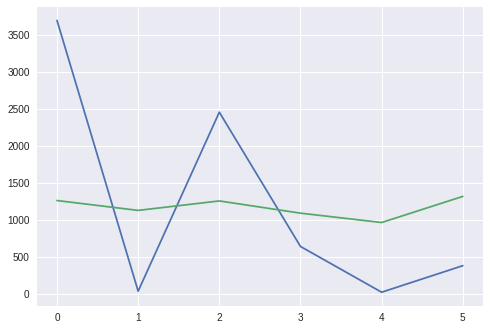

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output



def generateDist(gen,train):
  samples = gen.predict(np.random.rand(7000,100))
  sample_vars = []
  idx = 0
  for i in cat_vector:
    sample_vars.append()
    y = pd.get_dummies()
    if(i>0):
      x = np.array([np.random.choice(i,size=1,p=j) for j in samples[:,idx:i+idx]])
      sample_vars.append(pd.get_dummies(x[:,0]))
      idx=i+idx
    else:
      sample_vars.append(samples[:,idx:idx+1])
      idx = idx+1
  pd.concat(sample_vars,axis=1
  plt.plot(np.sum(train[:,0:6],axis=0))
  plt.plot(np.sum(sample_vars[0],axis=0))
  plt.show()

# Set training parameters

epochs = 60

positive_y = np.ones((BATCH_SIZE,1),dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE,1),dtype=np.float32)

for epoch in range(epochs):
  np.random.shuffle(X_train_onehot)
  disc_loss = []
  gen_loss = []
  minib_size = BATCH_SIZE*TRAINING_RATIO
  for i in range(X_train_onehot.shape[0] // minib_size):
    disc_minibatch = X_train_onehot[i*minib_size:(i+1)*minib_size]
    for j in range(TRAINING_RATIO):
      real_batch = disc_minibatch[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
      noise = np.random.rand(BATCH_SIZE,noise_size).astype(np.float32)
      disc_loss.append(disc_model.train_on_batch([real_batch,noise],[positive_y,negative_y,dummy_y]))
    gen_loss.append(generator_model.train_on_batch(np.random.rand(BATCH_SIZE,noise_size),positive_y))  
    #print(gen_loss[-1])
  if(((epoch/epochs)*100)%5==0):
    clear_output()
    print(epoch+1,"/",epochs," Epochs")
    generateDist(gen,X_train_onehot)

In [0]:
# 300 epochs did not get me anywhere
# Batch size 300 neither

import tensorflow as tf
samples = gen.predict(np.random.rand(7000,100))


#from tensorflow import one_hot, argmax
#sess = tf.Session()
#with sess.as_default():
#   samples_race = tf.one_hot(tf.argmax(samples[:,0:6], dimension = 1), depth = 6).eval()
#   samples_sex = tf.one_hot(tf.argmax(samples[:,6:8], dimension = 1), depth = 2).eval()
#   samples_age = tf.one_hot(tf.argmax(samples[:,8:11], dimension = 1), depth = 3).eval()
#print(np.sum(X_train_onehot,axis=0))
#print(np.sum(samples_race,axis=0))
#print(np.sum(samples_sex,axis=0))
#print(np.sum(samples_age,axis=0))



#plt.hist(samples[:,8:11])

#plt.plot(np.sum(X_train_onehot[:,0:6],axis=0))
#plt.plot(np.sum(samples[:,0:6],axis=0))

sample_vars = []

idx = 0
for i in cat_vector:
  #sample_vars.append()
  #y = pd.get_dummies()
  if(i>0):
    x = np.array([np.random.choice(i,size=1,p=j) for j in samples[:,idx:i+idx]])
    sample_vars.append(pd.get_dummies(x[:,0]))
    idx=i+idx
  else:
    sample_vars.append(samples[:,idx:idx+1])
    idx = idx+1
#pd.concat(sample_vars,axis=1
plt.plot(np.sum(X_train_onehot[:,8:11],axis=0))
plt.plot(np.sum(sample_vars[2],axis=0))
